In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os #dùng để xử lý đường dẫn, duyệt file
count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if count < 5:
            print(os.path.join(dirname, filename))
            count += 1

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml


In [ ]:
import xml.etree.ElementTree as ET #dùng để đọc và xử lý file XML
from tqdm import tqdm #để hiện thanh tiến trình khi duyệt nhiều phần tử

# Đường dẫn đến thư mục
ANNOTATIONS_DIR = "/kaggle/input/face-mask-detection/annotations"
IMAGES_DIR = "/kaggle/input/face-mask-detection/images"

In [ ]:
#import shutil
#shutil.rmtree("/kaggle/working/mask_dataset", ignore_errors=True)


## ĐỌC & IMPORT DỮ LIỆU

## TIỀN XỬ LÝ DỮ LIỆU
Vì dataset được chọn thuộc bài toán object detection, nên cần thực hiện bước tiền xử lý crop ảnh và gán riêng từng label cho bài toán image classification

Thực hiện annotation parsing. Sau đó preprocessing cho training, crop ảnh và lưu vào thư mục

Thư mục sẽ có dạng sau:

![{2B96360C-B1AD-43D2-A818-A5387F2377B2}.png](attachment:abe01d7e-da93-479b-9a36-f4aa6deac3e4.png)

In [ ]:
# Xác định nhãn trong bài toán
VALID_LABELS = {"with_mask", "without_mask", "mask_weared_incorrect"}
label_map = {
    "mask_weared_incorrect": 0,
    "with_mask": 1,
    "without_mask": 2
}
data = []

for filename in tqdm(os.listdir(ANNOTATIONS_DIR)):
    if not filename.endswith(".xml"):
        continue
    path = os.path.join(ANNOTATIONS_DIR, filename)
    tree = ET.parse(path)
    root = tree.getroot()

    image_name = root.find("filename").text

    for obj in root.findall("object"):
        label = obj.find("name").text

        # Dùng nhãn gốc, bỏ qua nếu không hợp lệ
        if label not in VALID_LABELS:
            continue
# Lấy toạ độ xmin, ymin, xmax, ymax	để crop vùng mặt từ ảnh gốc
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        data.append({
            "image_path": os.path.join(IMAGES_DIR, image_name),
            "label": label,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax
        })

df = pd.DataFrame(data)
df.head()

100%|██████████| 853/853 [00:00<00:00, 1089.19it/s]


,image_path,label,xmin,ymin,xmax,ymax
0,/kaggle/input/face-mask-detection/images/makss...,with_mask,28,55,46,71
1,/kaggle/input/face-mask-detection/images/makss...,with_mask,98,62,111,78
2,/kaggle/input/face-mask-detection/images/makss...,mask_weared_incorrect,159,50,193,90
3,/kaggle/input/face-mask-detection/images/makss...,with_mask,293,59,313,80
4,/kaggle/input/face-mask-detection/images/makss...,with_mask,352,51,372,72


In [ ]:
import cv2
from tqdm import tqdm

# Đường dẫn output
OUTPUT_DIR = "/kaggle/working/mask_dataset"

# Tạo thư mục cho từng nhãn
labels = df['label'].unique()
for label in labels:
    os.makedirs(os.path.join(OUTPUT_DIR, label), exist_ok=True)

# Bộ đếm riêng cho lớp 'mask_weared_incorrect'
mask_weared_incorrect_count = 0

# Duyệt từng dòng trong df để crop ảnh
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(row['image_path'])
    if img is None:
        continue

    # Cắt khuôn mặt
    face = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]

    # Lưu ảnh gốc
    out_path = os.path.join(OUTPUT_DIR, row['label'], f"{idx}.jpg")
    cv2.imwrite(out_path, face)

    # Augment CHỈ lớp 'mask_weared_incorrect' và đúng 50% ảnh
    if row['label'] == 'mask_weared_incorrect':
        mask_weared_incorrect_count += 1
        if mask_weared_incorrect_count % 2 == 0:  # Chỉ augment 50% ảnh mask_weared_incorrect
            # Flip
            flipped = cv2.flip(face, 1)

            # Rotate nhẹ ±15 độ
            (h, w) = face.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, 15, 1.0)
            rotated = cv2.warpAffine(face, M, (w, h))

            # Resize lớn hơn nhẹ
            resized = cv2.resize(face, (w + 10, h + 10))

            # Lưu ảnh augment
            aug_dir = os.path.join(OUTPUT_DIR, row['label'])
            cv2.imwrite(os.path.join(aug_dir, f"{idx}_flip.jpg"), flipped)
            cv2.imwrite(os.path.join(aug_dir, f"{idx}_rotate.jpg"), rotated)
            cv2.imwrite(os.path.join(aug_dir, f"{idx}_resize.jpg"), resized)


 14%|█▍        | 579/4072 [00:10<01:04, 53.79it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
100%|██████████| 4072/4072 [01:11<00:00, 57.32it/s]


ở lần đánh giá đầu tiên, điểm F-1 của label "mask_weared_incorrect" tỉ lệ recall chỉ đạt 55% so với with_mask đạt 99.5% => vì vậy augment riêng cho lớp này để sinh thêm dữ liệu, tránh mô hình bị thiên vị

In [ ]:
for label in ["with_mask", "mask_weared_incorrect", "without_mask"]:
    print(f"{label}: {len(os.listdir(os.path.join(OUTPUT_DIR, label)))} ảnh")


with_mask: 3232 ảnh
mask_weared_incorrect: 306 ảnh
without_mask: 717 ảnh


=> Số ảnh "mask_weared_incorrect" tăng từ 123 ảnh lên 306 ảnh

Tại sao lại tăng từ 123 lên 306?
Vì chọn augment 50% số ảnh của tập 'mask_weared_incorrect', với 50 ảnh này, đem đi augment thành 3 kiểu khác nhau.

123/2 = 61 ảnh
61 x 3 = 183 ảnh mới
123 (gốc) + 183 (mới) = 306 ảnh tất cả

In [ ]:
import torch # Thư viện chính để xây dựng và huấn luyện mô hình
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Khai báo transform để resize, augment, normalize

# Biến đổi dùng cho tập huấn luyện
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                   # Resize: về input chuẩn của EfficientNetB0
    transforms.RandomHorizontalFlip(),               # Augment: Lật ngang ngẫu nhiên
    transforms.RandomRotation(20),                   # Augment: Xoay ±20 độ
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),  # Augment: Làm sáng/tối/màu ngẫu nhiên
    transforms.ToTensor(),                           # Chuyển về tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize: chuẩn ImageNet
                         std=[0.229, 0.224, 0.225])
])

# Biến đổi dùng cho validation & test (không Augment)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# gán transform cho tập train
#Dùng ImageFolder để đọc ảnh trong thư mục `mask_dataset`, nơi ảnh đã được lưu theo 3 label đã gán:
DATA_DIR = "/kaggle/working/mask_dataset"
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)

# Chia train/val/test theo tỷ lệ 80/10/10
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Dùng random_split để chia
generator = torch.Generator().manual_seed(42)  # Đảm bảo chia giống nhau mỗi lần
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator)


In [ ]:
# Gán transform riêng cho val/test
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms


# Tạo DataLoader cho mỗi tập
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Kiểm tra tổng số ảnh mỗi tập
print(f"✅ Loaded: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")

#Hoàn thành chia tập dữ liệu train/val/test
#Hoàn thành tiền xử lý dữ liệu, chuyển qua bước LOAD TT EfficientNetB0

✅ Loaded: 3404 train, 425 val, 426 test


## HUẤN LUYỆN MÔ HÌNH
LOAD MODEL PRETRAINED EFFICIENTNETB0 TỪ PYTORCH
Source: https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load EfficientNetB0 kiến trúc (không weights từ internet)
model = models.efficientnet_b0(weights=None)

# Load pretrained weights thủ công
model.load_state_dict(torch.load("/kaggle/input/efficientnet_b0_rwightman-7f5810bc.pth/pytorch/default/1/efficientnet_b0_rwightman-7f5810bc.pth"))

# Điều chỉnh classifier cho 3 lớp
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)

# Đưa model lên GPU (nếu có, dùng Cuda để tăng tốc huấn luyện)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"✅ Using device: {device}")
print("✅ Loaded EfficientNetB0 từ file local thành công!")


✅ Using device: cpu
✅ Loaded EfficientNetB0 từ file local thành công!


In [ ]:
import torch.optim as optim

# Hàm loss (Đo lường mô hình sai lệch bao nhiêu) & optimizer (Cập nhật mô hình dựa vào loss để học tốt hơn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Số epoch
num_epochs = 10

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Chuyển sang chế độ train
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Forward & Loss
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation (tính gradient và cập nhật)
        optimizer.zero_grad()      # Reset gradient
        loss.backward()            # Tính gradient
        optimizer.step()           # Cập nhật trọng số
        # => Đây là 3 bước chuẩn của huấn luyện mô hình trong PyTorch

        # Tính toán loss và accuracy
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)            # Lấy label có xác suất cao nhất
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

#Trả về loss trung bình và accuracy (%) của epoch đó.
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()  # Chế độ đánh giá (tắt dropout, batchnorm)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Không tính toán gradient
        for images, labels in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

#Trả về loss trung bình và accuracy (%) của tập val
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
# Huấn luyện mô hình trong nhiều epoch và đánh giá kết quả trên tập validation sau mỗi epoch
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        # Hiển thị kết quả
        print(f"📉 Train Loss: {train_loss:.4f} | ✅ Train Acc: {train_acc:.4f}")
        print(f"📋 Val   Loss: {val_loss:.4f} | 🎯 Val   Acc: {val_acc:.4f}")

        # Lưu model mỗi epoch
        model_filename = f"efficientnet_epoch{epoch+1}_val{val_acc:.4f}.pth"
        torch.save(model.state_dict(), model_filename)
        print(f"💾 Saved: {model_filename}")

        # Lưu mô hình tốt nhất
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_efficientnet_b0.pth")
            print("🌟 New best model saved!")


In [ ]:
#Chạy hàm
train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

print("✅ Training completed!")


🔁 Epoch 1/10


Validating: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


📉 Train Loss: 0.5140 | ✅ Train Acc: 0.8305
📋 Val   Loss: 0.2538 | 🎯 Val   Acc: 0.8918
💾 Saved: efficientnet_epoch1_val0.8918.pth
🌟 New best model saved!

🔁 Epoch 2/10


Validating: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


📉 Train Loss: 0.1896 | ✅ Train Acc: 0.9333
📋 Val   Loss: 0.1271 | 🎯 Val   Acc: 0.9600
💾 Saved: efficientnet_epoch2_val0.9600.pth
🌟 New best model saved!

🔁 Epoch 3/10


Validating: 100%|██████████| 14/14 [00:16<00:00,  1.17s/it]


📉 Train Loss: 0.1027 | ✅ Train Acc: 0.9721
📋 Val   Loss: 0.1039 | 🎯 Val   Acc: 0.9671
💾 Saved: efficientnet_epoch3_val0.9671.pth
🌟 New best model saved!

🔁 Epoch 4/10


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]


📉 Train Loss: 0.0552 | ✅ Train Acc: 0.9841
📋 Val   Loss: 0.0805 | 🎯 Val   Acc: 0.9765
💾 Saved: efficientnet_epoch4_val0.9765.pth
🌟 New best model saved!

🔁 Epoch 5/10


Validating: 100%|██████████| 14/14 [00:14<00:00,  1.05s/it]


📉 Train Loss: 0.0416 | ✅ Train Acc: 0.9906
📋 Val   Loss: 0.0756 | 🎯 Val   Acc: 0.9741
💾 Saved: efficientnet_epoch5_val0.9741.pth

🔁 Epoch 6/10


Validating: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


📉 Train Loss: 0.0299 | ✅ Train Acc: 0.9915
📋 Val   Loss: 0.0862 | 🎯 Val   Acc: 0.9765
💾 Saved: efficientnet_epoch6_val0.9765.pth

🔁 Epoch 7/10


Validating: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


📉 Train Loss: 0.0291 | ✅ Train Acc: 0.9921
📋 Val   Loss: 0.0803 | 🎯 Val   Acc: 0.9765
💾 Saved: efficientnet_epoch7_val0.9765.pth

🔁 Epoch 8/10


Validating: 100%|██████████| 14/14 [00:14<00:00,  1.05s/it]


📉 Train Loss: 0.0238 | ✅ Train Acc: 0.9929
📋 Val   Loss: 0.0738 | 🎯 Val   Acc: 0.9741
💾 Saved: efficientnet_epoch8_val0.9741.pth

🔁 Epoch 9/10


Validating: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


📉 Train Loss: 0.0159 | ✅ Train Acc: 0.9959
📋 Val   Loss: 0.0751 | 🎯 Val   Acc: 0.9741
💾 Saved: efficientnet_epoch9_val0.9741.pth

🔁 Epoch 10/10


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]

📉 Train Loss: 0.0158 | ✅ Train Acc: 0.9959
📋 Val   Loss: 0.0555 | 🎯 Val   Acc: 0.9812
💾 Saved: efficientnet_epoch10_val0.9812.pth
🌟 New best model saved!
✅ Training completed!


## ĐÁNH GIÁ MÔ HÌNH

In [ ]:
# Load mô hình tốt nhất
model.load_state_dict(torch.load("best_efficientnet_b0.pth"))
model.eval()
model = model.to(device)

# Hàm đánh giá
def evaluate_model(model, test_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f"🎯 Test Accuracy: {acc:.4f}")
    return acc

# Gọi đánh giá
evaluate_model(model, test_loader, device)
#kết quả test trên tập test:

🎯 Test Accuracy: 0.9695


0.9694835680751174

In [ ]:
# Tạo y_true và y_pred

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [ ]:
# Đánh giá F-1 score và Recall score
from sklearn.metrics import f1_score, precision_score, recall_score

print("🎯 F1-scores:")
print("Macro:   ", f1_score(y_true, y_pred, average="macro"))
print("Micro:   ", f1_score(y_true, y_pred, average="micro"))
print("Weighted:", f1_score(y_true, y_pred, average="weighted"))

print("\n📈 Recall scores:")
print("Macro:   ", recall_score(y_true, y_pred, average="macro"))
print("Micro:   ", recall_score(y_true, y_pred, average="micro"))
print("Weighted:", recall_score(y_true, y_pred, average="weighted"))

🎯 F1-scores:
Macro:    0.942108217029103
Micro:    0.9694835680751174
Weighted: 0.9691177126047423

📈 Recall scores:
Macro:    0.9264281574135452
Micro:    0.9694835680751174
Weighted: 0.9694835680751174


Accuracy cao (97.62%), nhưng macro F1 thấp hơn đáng kể (94.21%) → cho thấy mô hình thiên lệch về lớp có nhiều dữ liệu (imbalance).

Weighted avg F1 cao vì được tính có trọng số theo số lượng mẫu từng lớp → phù hợp khi đánh giá trên tập không cân bằng.


In [ ]:
from sklearn.metrics import classification_report
class_names = ["mask_weared_incorrect", "with_mask", "without_mask"]
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


                       precision    recall  f1-score   support

mask_weared_incorrect     0.9667    0.8529    0.9062        34
            with_mask     0.9780    0.9904    0.9842       314
         without_mask     0.9359    0.9359    0.9359        78

             accuracy                         0.9695       426
            macro avg     0.9602    0.9264    0.9421       426
         weighted avg     0.9694    0.9695    0.9691       426



Lớp mask_weared_incorrect recall khá thấp → nhiều mẫu bị bỏ sót, tức là mô hình chưa phân biệt tốt các trường hợp "đeo sai khẩu trang".
Đây cũng là lớp có ít dữ liệu ảnh nhất (34 ảnh)

Lớp with_mask và without_mask có F1 cao → mô hình nhận diện tốt.

In [ ]:
# Dự đoán toàn bộ test set và lưu nhãn dự đoán
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán nhãn trên tập test
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [ ]:
# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)

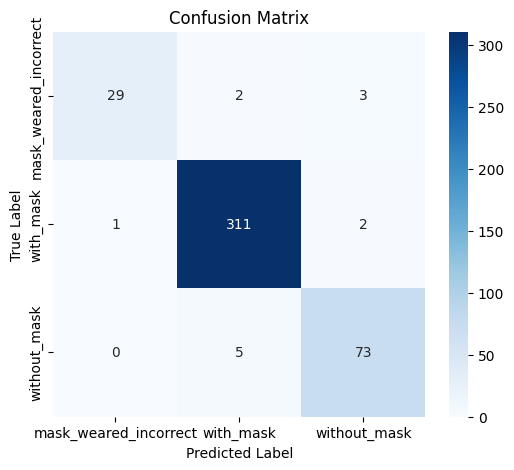

In [ ]:
#Vẽ confusion matrix
# Danh sách tên lớp theo đúng thứ tự ánh xạ
class_names = ["mask_weared_incorrect", "with_mask", "without_mask"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

=> Mô hình dự đoán tốt nhất lớp with_mask (311/314 ảnh đúng).

=> Lớp mask_weared_incorrect có tỷ lệ sai cao hơn (29/34 ảnh đúng).

=> Lớp without_mask nhận diện khá tốt (73/78 đúng).

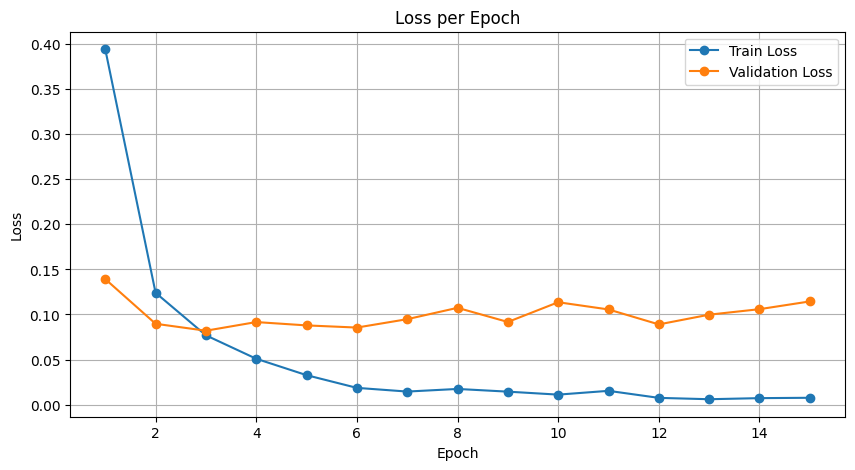

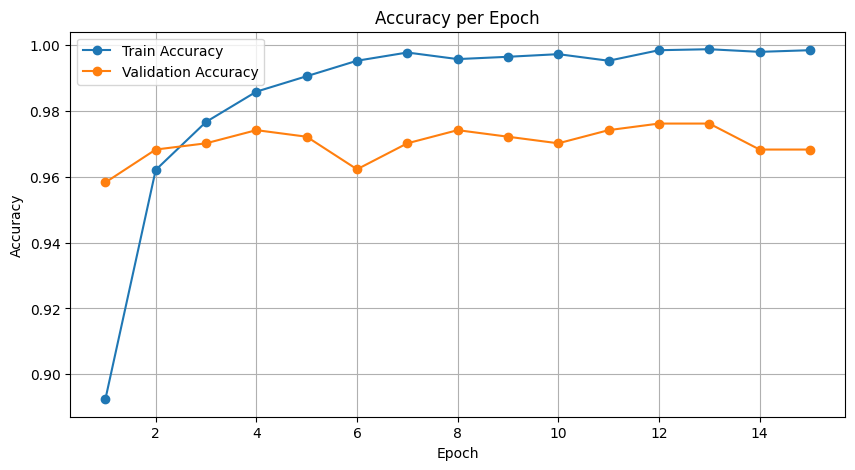

In [ ]:
#Ghi lại losses/accuracy từ 10 epoch train ở trên
train_accuracies = [
    0.8924, 0.9621, 0.9767, 0.9859, 0.9906,
    0.9953, 0.9978, 0.9958, 0.9965, 0.9973,
    0.9953, 0.9985, 0.9988, 0.9980, 0.9985
]

val_accuracies = [
    0.9583, 0.9683, 0.9702, 0.9742, 0.9722,
    0.9623, 0.9702, 0.9742, 0.9722, 0.9702,
    0.9742, 0.9762, 0.9762, 0.9683, 0.9683
]

train_losses = [
    0.3943, 0.1241, 0.0769, 0.0509, 0.0327,
    0.0186, 0.0145, 0.0174, 0.0144, 0.0111,
    0.0153, 0.0075, 0.0060, 0.0072, 0.0076
]

val_losses = [
    0.1393, 0.0897, 0.0820, 0.0916, 0.0879,
    0.0855, 0.0948, 0.1074, 0.0917, 0.1136,
    0.1056, 0.0890, 0.0998, 0.1059, 0.1145
]
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_accuracies) + 1))

# --- Biểu đồ Loss ---
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Biểu đồ Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#!zip efficientnet_model.zip best_efficientnet_b0.pth

In [ ]:
#from IPython.display import FileLink
#FileLink('efficientnet_model.zip')
